## Preparation: set up an account on Google Developer Console to acquire authorization

Follow the steps in the slides to get authorization, which can be a "server key".

## Getting started: import the libraries: json, pandas, and Google APIs

In [2]:
!pip install --upgrade google-api-python-client

     |████████████████████████████████| 58 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 5.5 MB/s  eta 0:00:01
     |████████████████████████████████| 89 kB 7.9 MB/s  eta 0:00:01
     |████████████████████████████████| 95 kB 4.7 MB/s  eta 0:00:01
     |████████████████████████████████| 1.3 MB 9.8 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 5.8 MB/s  eta 0:00:01
  Created wheel for googleapis-common-protos: filename=googleapis_common_protos-1.51.0-py3-none-any.whl size=77592 sha256=40946550ea18d60fb8c16c2fa7ba48a9f69c48729e5e26c7d404e718e1d6e7ae
  Stored in directory: /Users/DavidSummer/Library/Caches/pip/wheels/4c/a1/71/5e427276ceeff277fd76878d1b19fbf4587a2845015d86864b
Successfully built googleapis-common-protos


In [3]:
import json
import pandas as pd
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

## Define a YouTubeCommenents class that has the following functionalities:
- build a *service* object that can be used to call methods from Google API
- call the *service.search().list()* method to get a list of videos that match your search criteria 
- call the *service.video().list()* method to return the properties for the videos (See here for a list of parameters for this method: 
- call the *service.commentsThreads().list()* method to get a list comments for a given video 
- For a list of parameters for these methods, refer to https://developers.google.com/youtube/v3/docs/search/list

In [4]:
class YouTubeComments(object):
    def __init__(self, service_name, service_version, api_key):
        """

        :param service_name: google api service name, in this case "youtube"
        :param service_version: api version, in this case "v3"
        :param api_key: api key
        """
        self.service_name = service_name
        self.service_version = service_version
        self.service = build(self.service_name, self.service_version, developerKey=api_key)
        self.video_info = None

    def keyword_search(self, keyword, max_items=5, after="2000-01-01T00:00:00Z", before="2020-12-31T00:00:00Z", stats=False, to_csv=False):
        """

        :param keyword: query string in youtube search box
        :param max_items: returned item (video, channel, youtuber) number
        :param stats: Apart from v_id and v_title, also including
                common statistics (viewCount,likeCount,dislikeCount,favoriteCount,commentCount)
        :param to_csv: output a video_stats_{keyword}.csv file
        :return:
        """
        raw_results = self.service.search().list(
            q=keyword,
            type="video",
            part="id,snippet",
            publishedAfter=after,
            publishedBefore=before,
            maxResults=max_items).execute()
        basic_v_info = {}
        for result in raw_results.get("items", []):
            if result["id"]["kind"] == "youtube#video":
                #print ("Video published at "+ result["snippet"]["publishedAt"])
                basic_v_info[result["id"]["videoId"]] = result["snippet"]["publishedAt"] + " " + result["snippet"]["title"]
        if stats:
            self.video_info = self._get_stats(basic_v_info)
        else:
            self.video_info = [dict(v_id=k, v_title=v) for k, v in basic_v_info]
        if to_csv:
            self.info2csv(out_file=f"video_stats_{keyword}.csv")

    def _get_stats(self, basic_v_info):
        """
        helper function to get the video statistics
        :param basic_v_info:
        :return:
        """
        v_ids = ','.join(basic_v_info.keys())
        videos_stats = self.service.videos().list(
            id=v_ids,
            part='id,statistics'
        ).execute()
        video_info = []
        for i in videos_stats['items']:
            temp = dict(v_id=i['id'], v_title=basic_v_info[i['id']])
            temp.update(i['statistics'])
            video_info.append(temp)
        return video_info

    def info2csv(self, out_file="video_stats.csv"):
        """
        output video info into csv
        :param out_file:
        :return:
        """
        df = pd.DataFrame.from_dict(self.video_info)
        df.to_csv(out_file, index=False)
        print(f"Save {out_file} successfully!")

    def get_video_comments(self, v_id, max_c=50, verbose=False):
        """
        given a video id, return a list of comments of the video
        :param v_id: unique youtube video id
        :param max_c: returned number of the comments
        :param verbose: output the raw comments information into json file
        :return: a list of comments of a video
        """
        comments = []
        try:
            results = self.service.commentThreads().list(part='snippet',
                                                         videoId=v_id,
                                                         textFormat='plainText',
                                                         order="time",
                                                         maxResults=max_c).execute()
            if verbose:
                with open(f'{v_id}_raw_comments.json', 'w', encoding='utf-8') as f:
                    json.dump(results, f, indent=4)
            for item in results['items']:
                comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
                comments.append(comment)
                publication_date = item['snippet']['topLevelComment']['snippet']['publishedAt']
                comments.append(publication_date)
                author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
                comments.append(author)
                print(author + " " + publication_date + " Comment: " + comment)
        except HttpError:
            print("Comment disabled by http error!")
        except UnicodeEncodeError:
            print("Encoding error!")
        return comments

    def get_all_comments(self, max_per_v=1000, out_file="all_comments.json"):
        """
        output the comments and basic videos info into json
        :param max_per_v: returned comment number of each video
        :param out_file:
        :return:
        """
        v_info = [(d['v_id'], d['v_title']) for d in self.video_info]
        v_ids = [i for i, _ in v_info]
        v_titles = [i for _, i in v_info]
        out = {}
        for i, v_id in enumerate(v_ids):
            print ("\n\nVideo Title: " + v_titles[i])
            comments = self.get_video_comments(v_id, max_c=max_per_v, verbose=True)
            out[str(i)] = {'id': v_id, 'title': v_titles[i], "comments": comments}
        with open(out_file, 'w') as f:
            json.dump(out, f, indent=4)
            print(f"Finish dumping {out_file}!")


*service.search().list()* returns:
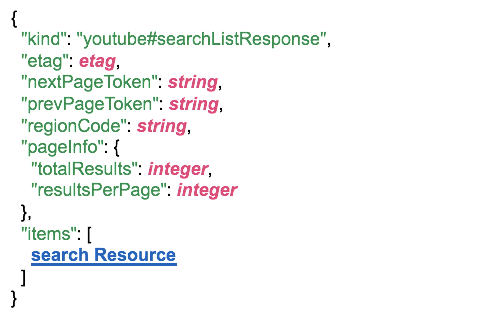

JSON for *Search Resource*:
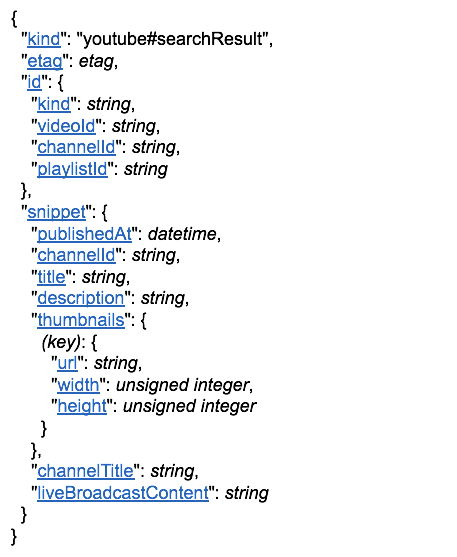

*service.video().list()* returns: 
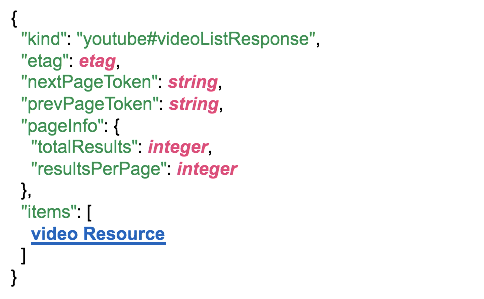

JSON for *Video Resource*:
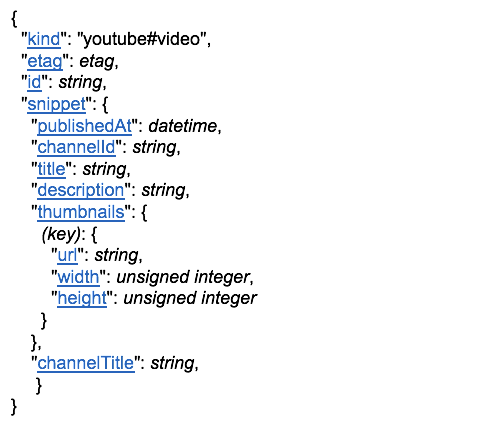

*service.CommmentsThreads().list()* returns:
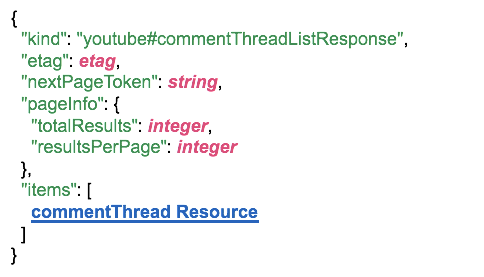

JSON for *Comments Thread Resource*:
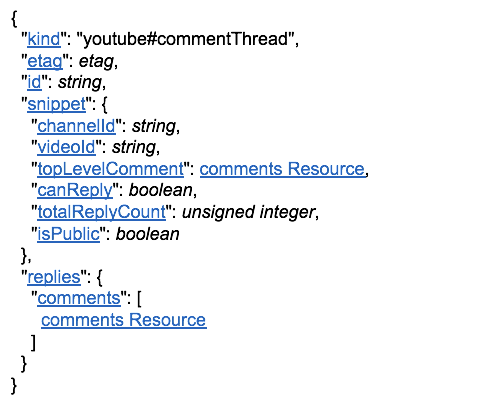

JSON for *Comment Resource*:
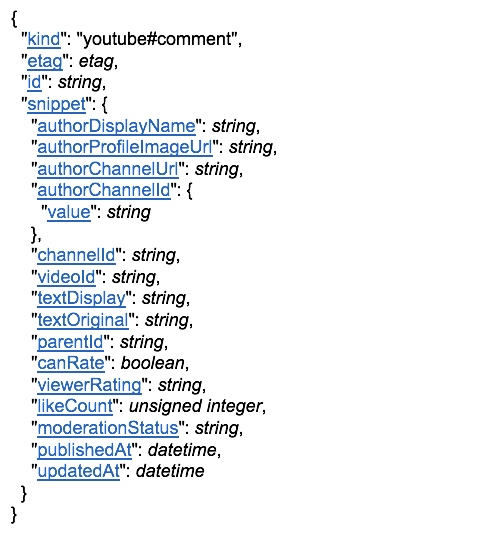

## Use the method below to collect comments on videos about a particular topic:

In [24]:
if __name__ == "__main__":
    YOUTUBE_API_SERVICE_NAME = "youtube"
    YOUTUBE_API_VERSION = "v3"
    DEVELOPER_KEY = " "
    cjy = YouTubeComments(YOUTUBE_API_SERVICE_NAME, YOUTUBE_API_VERSION, DEVELOPER_KEY)

    cjy.keyword_search('study chinese', max_items=50, after="2019-01-01T00:00:00Z", before="2019-01-03T00:00:00Z", stats=True, to_csv=True)
    cjy.get_all_comments()

Save video_stats_study chinese.csv successfully!


Video Title: 2019-01-02T04:07:37.000Z រៀនភាសាចិន​​  学中文 Study Chinese Language


Video Title: 2019-01-02T05:36:13.000Z How I study Chinese. How I learn Chinese part 2


Video Title: 2019-01-01T16:54:17.000Z STUDY WITH ME(Chinese High School  student )
Comment disabled by http error!


Video Title: 2019-01-02T04:54:56.000Z Study MBBS in China ~ Qingdao University
Gank Preglo 2019-02-22T03:11:42Z Comment: Qingdao is a beautiful city
Zuoye Samuel 2019-02-21T03:30:59Z Comment: I would love to see more videos about this university, please upload.
Amisha Sharma 2019-02-20T03:25:21Z Comment: This is one of the best University in Shandong province and I like the city too. I went here last summer vacation holiday.
Laura Patrick 2019-02-19T13:59:35Z Comment: The city is also beautiful, I wish I could visit someday here.
Alisa Trang 2019-02-17T03:09:42Z Comment: This is where I am studying now 👍👍👍👍👍👍


Video Title: 2019-01-01T14:38:04.000Z Hit Fm